In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from tqdm import tqdm

In [8]:
# Configuration
class Config:
    TRAIN_DIR = 'waste_classification_v1/garbage-dataset/tmp/train'  # Replace with the path to your training data
    VAL_DIR = 'waste_classification_v1/garbage-dataset/tmp/validation'      # Replace with the path to your validation data
    TEST_DIR = 'waste_classification_v1/garbage-dataset/'    # Replace with the path to your test data
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 25
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    MODEL_PATH = 'best_cnn_model.pth'

In [9]:
# Data Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
# Load Datasets
train_dataset = datasets.ImageFolder(Config.TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(Config.VAL_DIR, transform=val_transforms)
test_dataset = datasets.ImageFolder(Config.TEST_DIR, transform=val_transforms)

In [11]:
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [13]:
# Define Model
class WasteAtlasCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteAtlasCNN, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [14]:
# Initialize Model
model = WasteAtlasCNN(num_classes=len(train_dataset.classes)).to(Config.DEVICE)

d:\Software Programming\ProgrammingWorks\Python\Streamlit\mlpytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Software Programming\ProgrammingWorks\Python\Streamlit\mlpytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

d:\Software Programming\ProgrammingWorks\Python\Streamlit\mlpytorch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(Config.DEVICE)
                labels = labels.to(Config.DEVICE)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step(running_loss)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                torch.save(model.state_dict(), Config.MODEL_PATH)

        print()

    print(f'Best val Acc: {best_accuracy:.4f}')

    return best_accuracy

In [17]:
# Train the model
best_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=Config.NUM_EPOCHS)

print(f'\nBest Validation Accuracy: {best_accuracy:.2f}%')

Epoch 1/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.86it/s]


train Loss: 0.9496 Acc: 0.6912


val: 100%|██████████| 122/122 [00:19<00:00,  6.25it/s]


val Loss: 0.9004 Acc: 0.7034

Epoch 2/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.90it/s]


train Loss: 0.5714 Acc: 0.8153


val: 100%|██████████| 122/122 [00:19<00:00,  6.34it/s]


val Loss: 0.5817 Acc: 0.7981

Epoch 3/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.87it/s]


train Loss: 0.4455 Acc: 0.8529


val: 100%|██████████| 122/122 [00:18<00:00,  6.42it/s]


val Loss: 0.4319 Acc: 0.8594

Epoch 4/25
----------


train: 100%|██████████| 486/486 [01:38<00:00,  4.92it/s]


train Loss: 0.3815 Acc: 0.8750


val: 100%|██████████| 122/122 [00:19<00:00,  6.35it/s]


val Loss: 0.4915 Acc: 0.8494

Epoch 5/25
----------


train: 100%|██████████| 486/486 [01:38<00:00,  4.91it/s]


train Loss: 0.3424 Acc: 0.8863


val: 100%|██████████| 122/122 [00:19<00:00,  6.42it/s]


val Loss: 0.4269 Acc: 0.8643

Epoch 6/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.90it/s]


train Loss: 0.3071 Acc: 0.8995


val: 100%|██████████| 122/122 [00:19<00:00,  6.39it/s]


val Loss: 0.5852 Acc: 0.8229

Epoch 7/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.90it/s]


train Loss: 0.2747 Acc: 0.9106


val: 100%|██████████| 122/122 [00:19<00:00,  6.40it/s]


val Loss: 0.4682 Acc: 0.8589

Epoch 8/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.90it/s]


train Loss: 0.2567 Acc: 0.9138


val: 100%|██████████| 122/122 [00:19<00:00,  6.41it/s]


val Loss: 0.3704 Acc: 0.8829

Epoch 9/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.91it/s]


train Loss: 0.2142 Acc: 0.9292


val: 100%|██████████| 122/122 [00:19<00:00,  6.42it/s]


val Loss: 0.4245 Acc: 0.8689

Epoch 10/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.90it/s]


train Loss: 0.1878 Acc: 0.9381


val: 100%|██████████| 122/122 [00:19<00:00,  6.40it/s]


val Loss: 0.3806 Acc: 0.8849

Epoch 11/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.91it/s]


train Loss: 0.2028 Acc: 0.9334


val: 100%|██████████| 122/122 [00:19<00:00,  6.34it/s]


val Loss: 0.4551 Acc: 0.8684

Epoch 12/25
----------


train: 100%|██████████| 486/486 [01:38<00:00,  4.91it/s]


train Loss: 0.1839 Acc: 0.9383


val: 100%|██████████| 122/122 [00:19<00:00,  6.36it/s]


val Loss: 0.5120 Acc: 0.8535

Epoch 13/25
----------


train: 100%|██████████| 486/486 [01:38<00:00,  4.91it/s]


train Loss: 0.1713 Acc: 0.9434


val: 100%|██████████| 122/122 [00:19<00:00,  6.34it/s]


val Loss: 0.3423 Acc: 0.8932

Epoch 14/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.89it/s]


train Loss: 0.1464 Acc: 0.9518


val: 100%|██████████| 122/122 [00:19<00:00,  6.38it/s]


val Loss: 0.3814 Acc: 0.8908

Epoch 15/25
----------


train: 100%|██████████| 486/486 [01:38<00:00,  4.91it/s]


train Loss: 0.1271 Acc: 0.9583


val: 100%|██████████| 122/122 [00:19<00:00,  6.34it/s]


val Loss: 0.4443 Acc: 0.8682

Epoch 16/25
----------


train: 100%|██████████| 486/486 [01:38<00:00,  4.91it/s]


train Loss: 0.1406 Acc: 0.9521


val: 100%|██████████| 122/122 [00:19<00:00,  6.40it/s]


val Loss: 0.4074 Acc: 0.8885

Epoch 17/25
----------


train: 100%|██████████| 486/486 [01:38<00:00,  4.93it/s]


train Loss: 0.1253 Acc: 0.9579


val: 100%|██████████| 122/122 [00:18<00:00,  6.43it/s]


val Loss: 0.4075 Acc: 0.8952

Epoch 18/25
----------


train: 100%|██████████| 486/486 [01:38<00:00,  4.91it/s]


train Loss: 0.1420 Acc: 0.9532


val: 100%|██████████| 122/122 [00:18<00:00,  6.43it/s]


val Loss: 0.4612 Acc: 0.8792

Epoch 19/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.91it/s]


train Loss: 0.1437 Acc: 0.9516


val: 100%|██████████| 122/122 [00:19<00:00,  6.17it/s]


val Loss: 0.3811 Acc: 0.8993

Epoch 20/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.87it/s]


train Loss: 0.0919 Acc: 0.9680


val: 100%|██████████| 122/122 [00:19<00:00,  6.34it/s]


val Loss: 0.3136 Acc: 0.9117

Epoch 21/25
----------


train: 100%|██████████| 486/486 [01:43<00:00,  4.70it/s]


train Loss: 0.0877 Acc: 0.9702


val: 100%|██████████| 122/122 [00:19<00:00,  6.24it/s]


val Loss: 0.3359 Acc: 0.9122

Epoch 22/25
----------


train: 100%|██████████| 486/486 [01:40<00:00,  4.86it/s]


train Loss: 0.1112 Acc: 0.9634


val: 100%|██████████| 122/122 [00:19<00:00,  6.37it/s]


val Loss: 0.3397 Acc: 0.9083

Epoch 23/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.90it/s]


train Loss: 0.1070 Acc: 0.9644


val: 100%|██████████| 122/122 [00:19<00:00,  6.34it/s]


val Loss: 0.3176 Acc: 0.9189

Epoch 24/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.89it/s]


train Loss: 0.0658 Acc: 0.9773


val: 100%|██████████| 122/122 [00:19<00:00,  6.30it/s]


val Loss: 0.5462 Acc: 0.8633

Epoch 25/25
----------


train: 100%|██████████| 486/486 [01:39<00:00,  4.89it/s]


train Loss: 0.0908 Acc: 0.9695


val: 100%|██████████| 122/122 [00:19<00:00,  6.25it/s]

val Loss: 0.4985 Acc: 0.8720

Best val Acc: 0.9189

Best Validation Accuracy: 0.92%


In [18]:
# Load the best model
model.load_state_dict(torch.load(Config.MODEL_PATH))


C:\Users\USER\AppData\Local\Temp\ipykernel_26928\801239133.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Config.MODEL_PATH))


<All keys matched successfully>

In [19]:
# Test the model
model.eval()
running_corrects = 0

for inputs, labels in tqdm(test_loader, desc='test'):
    inputs = inputs.to(Config.DEVICE)
    labels = labels.to(Config.DEVICE)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

test_accuracy = running_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

test: 100%|██████████| 1213/1213 [01:32<00:00, 13.12it/s]

Test Accuracy: 0.4873


In [20]:
# Class Names
print("\nClass Labels:")
for i, class_name in enumerate(train_dataset.classes):
    print(f"{i}: {class_name}")


Class Labels:
0: battery
1: biological
2: cardboard
3: clothes
4: glass
5: metal
6: paper
7: plastic
8: shoes
9: trash


C:\Users\USER\AppData\Local\Temp\ipykernel_26928\2059448321.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth', map_lo

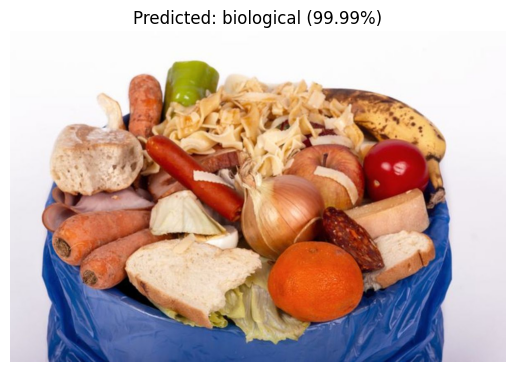

In [23]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load the model
model = WasteAtlasCNN(num_classes=10)
model.load_state_dict(torch.load('best_cnn_model.pth', map_location=torch.device('cpu')))
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = 'foodwaste.jpg'  # Replace with the path to your image
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)

# Make a prediction
with torch.no_grad():
    output = model(image)
    probabilities = F.softmax(output, dim=1)
    confidence, predicted = torch.max(probabilities, 1)

# Interpret the prediction
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']  # Replace with your actual class names
predicted_class = class_names[predicted.item()]
confidence = confidence.item() * 100  # Convert to percentage

# Display the image and prediction
plt.imshow(Image.open(image_path))
plt.title(f'Predicted: {predicted_class} ({confidence:.2f}%)')
plt.axis('off')
plt.show()

THIS IS THE CODE REFERENCE WHEN USING IT IN THE WEBSITE